# RRSG With RIESLING

This Notebook shows how RIESLING can be used to reconstruct the ISMRM Reproducible Research Study Group cg-SENSE Challenge dataset:

O. Maier et al., ‘CG‐SENSE revisited: Results from the first ISMRM reproducibility challenge’, Magnetic Resonance in Medicine, Nov. 2020, doi: 10.1002/mrm.28569.


In [1]:
%reload_ext autoreload
%autoreload 2
%env RL_VERBOSITY=0
import riesling as rl

env: RL_VERBOSITY=0


First, we download the RRSG data from Zenodo

In [2]:
import os
import requests
zenodo_files=['rawdata_brain_radial_96proj_12ch.h5', 'rawdata_spiral_ETH.h5']
data_dir = 'rrsg'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

for zf in zenodo_files:
    if not os.path.isfile(f'{data_dir}/{zf}'):
        print(f'Downloading {zf}')
        res = requests.get(f'https://zenodo.org/record/3975887/files/{zf}')
        with open(f'{data_dir}/{zf}', 'wb') as h5f:
            h5f.write(res.content)
    else:
        print(f'Already downloaded {zf}')

Already downloaded rawdata_brain_radial_96proj_12ch.h5
Already downloaded rawdata_spiral_ETH.h5


Then we convert from the RRSG format to the RIESLING format. A utility function is provided in `riesling_rrsg.py` for this. We need to supply the desired matrix and voxel sizes.

In [3]:
import h5py
import numpy as np
matrix_sizes = [[256, 256, 1], [220, 220, 1]]
voxel_sizes = [[0.78, 0.78, 2], [1, 1, 2]]
scales = [1e8, 1]
radial_stem = 'rrsg-radial'
spiral_stem = 'rrsg-spiral'
rpre=f'{data_dir}/{radial_stem}'
spre=f'{data_dir}/{spiral_stem}'
riesling_files = [f'{radial_stem}.h5', f'{spiral_stem}.h5']
for (inname, mtx, vox, scale, outname) in zip(zenodo_files, matrix_sizes, voxel_sizes, scales, riesling_files):
    with h5py.File(f'{data_dir}/{inname}', 'r') as data_f:
        rawdata = data_f['rawdata'][...][np.newaxis,...].transpose((0,1,3,2,4))
        traj = data_f['trajectory'][...]
    # Scale trajectory
    traj = traj/np.max(abs(traj)) * 0.5
    traj = traj.transpose((2, 1, 0))
    if traj.shape[2] == 3: # Strip 3rd dimension of radial dataset
        traj = traj[:,:,0:2]
    rl.data.write_noncartesian(f'{data_dir}/{outname}', rawdata, traj, mtx, vox)

Finally, specify which reconstructions with which options we want to do.

In [4]:
algos={'cg':'cg', 'lsmr':'lsmr', 'tv':'admm', 'tgv':'admm'}
recons=['cg', 'lsmr', 'tv', 'tgv']
titles=['CG', 'LSMR', 'TV', 'TGV']
opts={'recon':f'',
      'cg':f'',
      'lsmr':f'',
      'tv':f'--tv --lambda=1e-2',
      'tgv':f'--tgv --lambda=1e-2'}

## Radial Dataset

First, we plot the trajectory and raw data to confirm this is a 2D radial dataset.

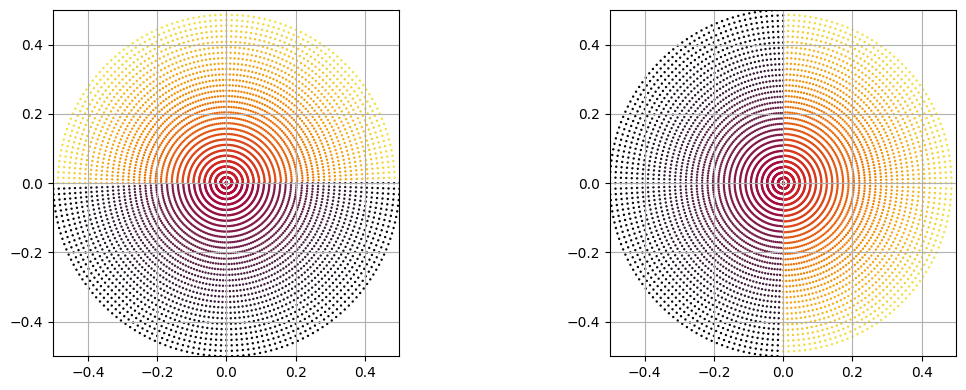

In [5]:
rl.plot.traj2d(f'{rpre}.h5', read_slice=slice(0,-1,8))

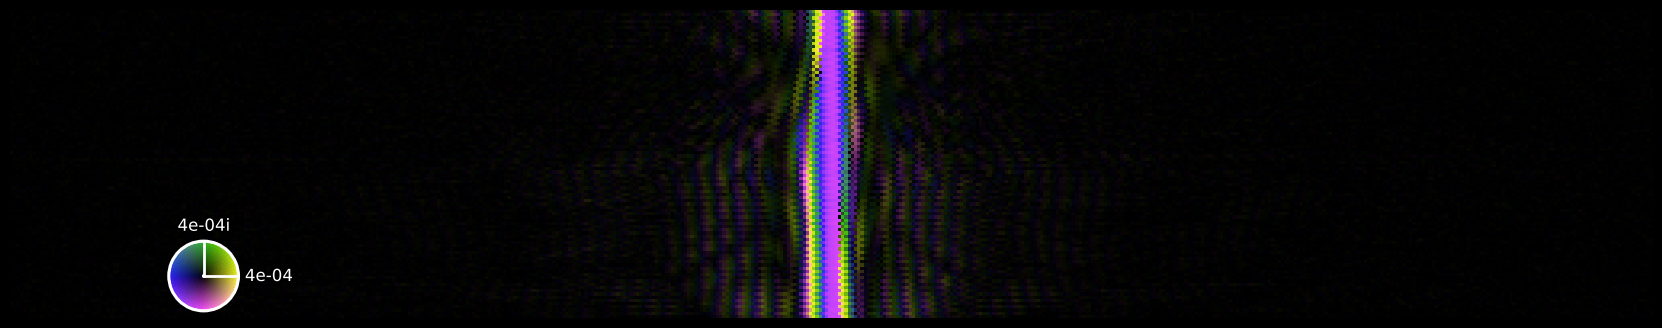

In [6]:
rl.plot.noncart(f'{rpre}.h5', transpose=True)

Pre-calculate some SENSE maps as these are the same across all reconstructions

In [7]:
!riesling sense-calib --osamp=2.5 {rpre}.h5 --sdc-its=10 --out {rpre} --sense-fov= 300,300,0 --sense-res=20
# display(rl.plot.sense(f'{rpre}-sense.h5',rows=2,rotates=1))

Then we reconstruct the image with the different methods available in `riesling` and compare the outcomes. Note that because we are processing the data in a subdirectory, it is necessary to use the `--out` argument, otherwise the data would be written in the parent directory. We specify the Field-of-View with `--fov` as directed in the paper.

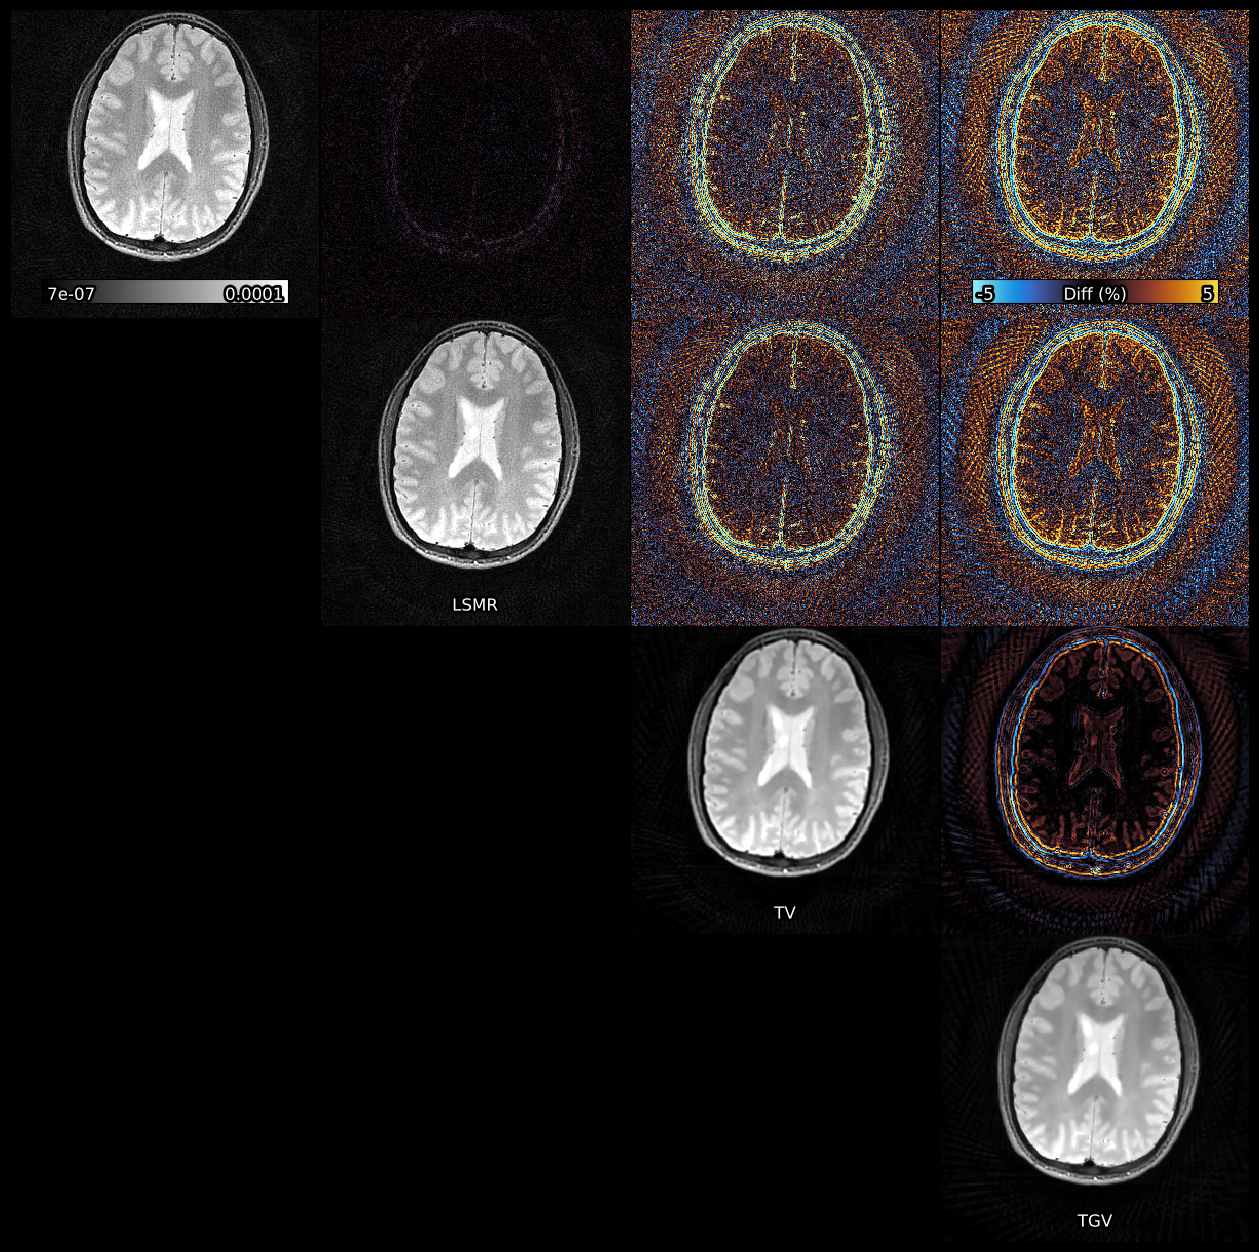

In [8]:
common=f'--fov=234 --osamp=2.5 --sense={rpre}-sense.h5'
for t in recons:
    !riesling {algos[t]} {opts[t]} {rpre}.h5 --out={rpre}-{t} {common} --debug={rpre}-{t}-debug.h5
files=[f'{rpre}-{t}-{algos[t]}.h5' for t in recons]
rl.plot.diff_matrix(files, titles=titles, difflim=[-5,5], rotates=1)

## Spiral Dataset

Now we repeat the above for the spiral dataset. The data size is pathological so don't plot the raw data.

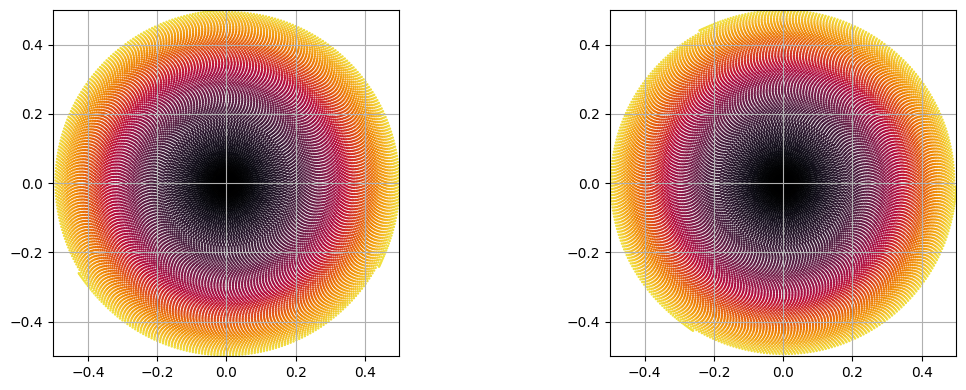

In [9]:
rl.plot.traj2d(f'{spre}.h5', read_slice=slice(None,None,4))

In [10]:
!riesling sense-calib {spre}.h5 --sense-res=20 --out {spre}
# display(rl.plot.sense(f'{spre}-sense.h5', rows=2, rotates=3))

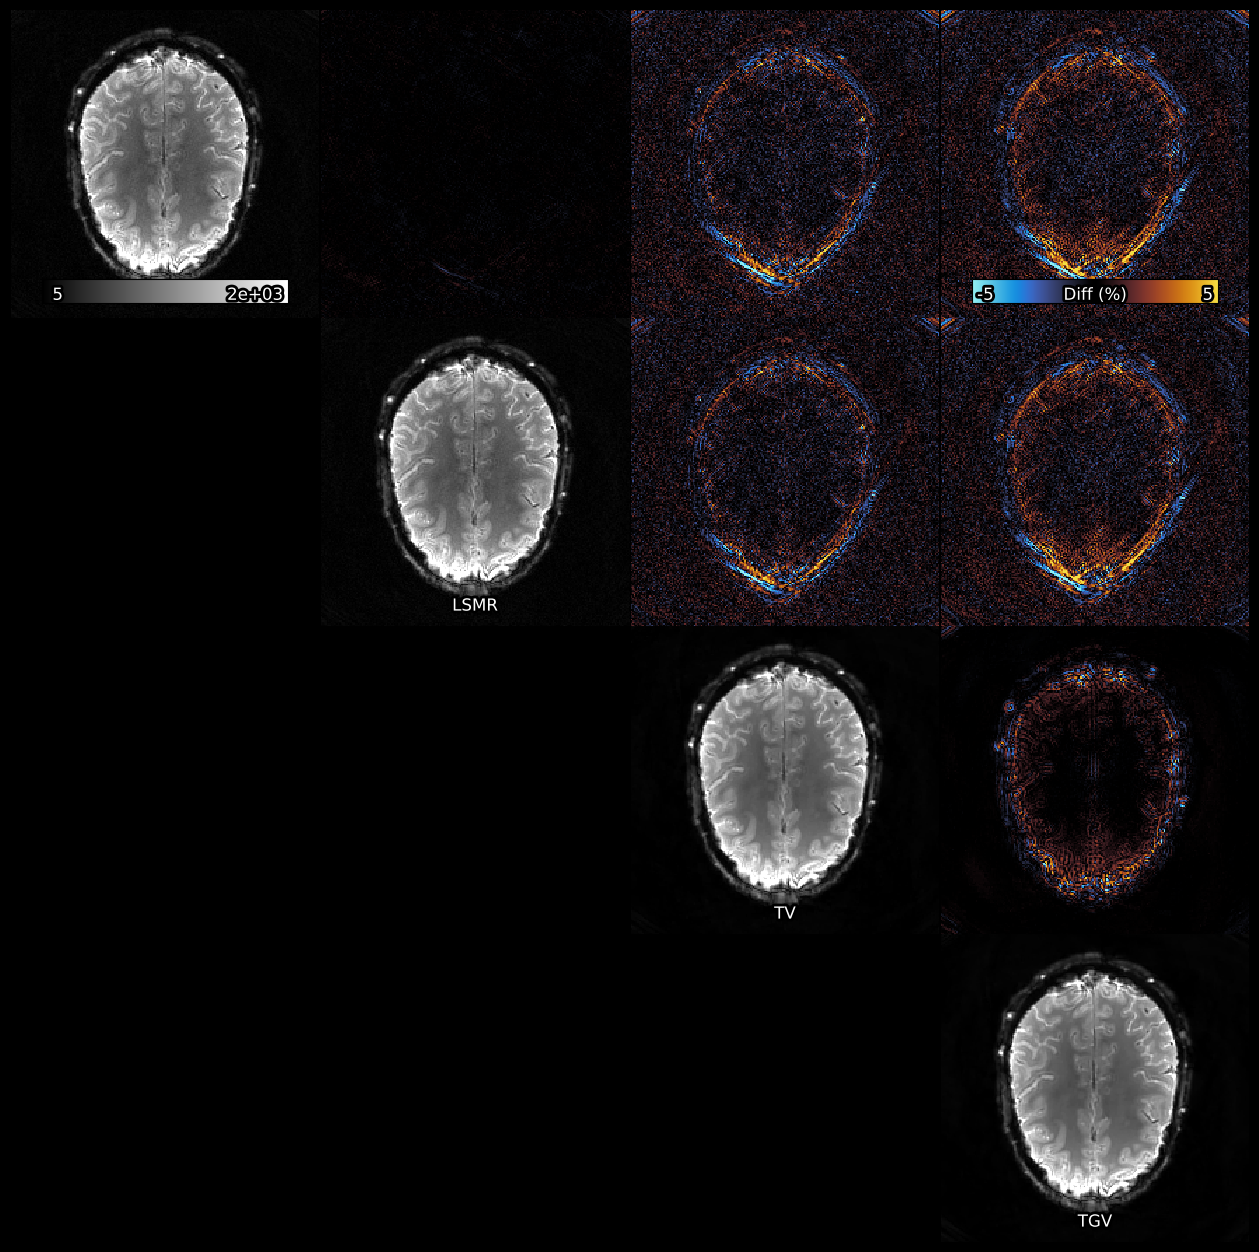

In [11]:
common=f'--sense={spre}-sense.h5'
for t in recons:
    !riesling {algos[t]} {opts[t]} {spre}.h5 --out={spre}-{t} {common} --debug={spre}-{t}-debug.h5
files=[f'{spre}-{t}-{algos[t]}.h5' for t in recons]
rl.plot.diff_matrix(files, titles=titles, difflim=[-5,5], rotates=1)